In [3]:
import networkx as nx
import torch
import os
import pandas as pd
from torch_geometric.data import Data
import numpy as np
from dateutil.parser import parse
from torch.utils.tensorboard import SummaryWriter

In [30]:
# process data
# each node is a team (for a year), edges
game_info = pd.read_csv("nfl-game-info.csv")
# team_info = pd.read_csv("team_stats_2003_2023.csv")

teams = pd.concat([game_info['Home Team'], game_info['Away Team']]).unique()
teams = list(teams)
teams.remove('San Diego Chargers')
teams.remove('Washington Redskins')
teams.remove('St. Louis Rams')
teams.remove('Oakland Raiders')
teams.remove('Washington Football Team')
teams = np.array(teams)
print(teams)
team_to_idx = {team: i for i, team in enumerate(teams)}

edge_index = []
edge_attr = []

for _, row in game_info.iterrows():
  date = parse(row["Date"])
  if date < parse('2024-9-5'):
    continue
  # create an edge between two teams,
  team1_idx = team_to_idx[row['Home Team']]
  team2_idx = team_to_idx[row['Away Team']]

  # Add an undirected edge (team1 -> team2 and team2 -> team1)
  edge_index.append([team1_idx, team2_idx])
  edge_index.append([team2_idx, team1_idx])

  edge_attr.append([row["Home Score"], row["Away Score"]])
  edge_attr.append([row["Away Score"], row["Home Score"]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float)

data = Data(edge_index=edge_index, edge_attr=edge_attr, num_nodes=len(teams))
print(data)

['Pittsburgh Steelers' 'San Francisco 49ers' 'Denver Broncos'
 'Las Vegas Raiders' 'Washington Commanders' 'Los Angeles Chargers'
 'Seattle Seahawks' 'Cincinnati Bengals' 'Cleveland Browns'
 'Detroit Lions' 'Houston Texans' 'Jacksonville Jaguars' 'Miami Dolphins'
 'New England Patriots' 'Tampa Bay Buccaneers' 'Los Angeles Rams'
 'Arizona Cardinals' 'Atlanta Falcons' 'Buffalo Bills' 'Green Bay Packers'
 'Indianapolis Colts' 'Minnesota Vikings' 'New York Giants'
 'New Orleans Saints' 'New York Jets' 'Carolina Panthers' 'Dallas Cowboys'
 'Baltimore Ravens' 'Philadelphia Eagles' 'Tennessee Titans'
 'Chicago Bears' 'Kansas City Chiefs']
Data(edge_index=[2, 246], edge_attr=[246, 2], num_nodes=32)


In [16]:
from torch_geometric.nn import GATConv
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_networkx
import torch.nn.functional as F

In [ ]:
num_nodes = len(teams)
node_feature_dim = 64
node_features = torch.randn((num_nodes, node_feature_dim), dtype=torch.float,)

# # RESIDUALS!
class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, heads=8, dropout=0.6):
        super(GATModel, self).__init__()
        self.dropout = dropout
        self.num_layers = num_layers
        self.heads = heads
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.in_channels = in_channels

        # Define GAT layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(in_channels, hidden_channels, heads=heads, concat=True, dropout=dropout))

        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads, concat=True, dropout=dropout))

        self.convs.append(GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout))

        self.bns = torch.nn.ModuleList([
            torch.nn.BatchNorm1d(hidden_channels * heads) for _ in range(num_layers - 1)
        ])

        # Linear projection for residual connections (if dimensions don't match)
        self.residual_proj = torch.nn.ModuleList([
            torch.nn.Linear(in_channels if i == 0 else hidden_channels * heads, hidden_channels * heads) 
            for i in range(num_layers - 1)
        ])

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs[:-1]):
            residual = x
            x = conv(x, edge_index)
            x = self.bns[i](x)
            x = F.elu(x)
            if residual.size(-1) != x.size(-1):
                residual = self.residual_proj[i](residual)

            x = x + residual    # Add residual connection
            x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.convs[-1](x, edge_index)
        return x

    def encode(self, x, edge_index):
        return self.forward(x, edge_index)

    def decode(self, z, edge_index):
        # Use dot product to predict if an edge exists
        src, dst = edge_index
        return (z[src] * z[dst]).sum(dim=1)

model = GATModel(in_channels=node_feature_dim, hidden_channels=32, out_channels=16, num_layers=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)
node_features = node_features.to(device)

with torch.no_grad():
    embeddings = model(node_features, data.edge_index)

print("GAT Embeddings:")
print(embeddings)

GAT Embeddings:
tensor([[ 9.8153e+00, -9.6728e+00, -1.1827e+01,  1.1813e+01,  1.3209e+01,
          9.4814e+00, -1.2816e+01,  3.8839e+00,  1.9963e+00,  3.3772e+00,
         -6.8188e+00, -2.8589e+01, -9.8338e+00, -2.0174e+01,  2.6742e+01,
         -1.0816e+01],
        [ 1.7525e-04,  3.3282e-04,  3.9908e-04,  8.4477e-04, -3.2050e-04,
          1.1383e-03, -5.9212e-04, -6.2921e-05,  6.0867e-04, -4.5408e-04,
          7.2130e-05, -4.8047e-04, -3.7052e-04,  9.1166e-05, -7.7439e-04,
         -1.0674e-03],
        [ 7.8230e+00,  7.2353e+00,  2.1517e-01, -1.4638e+01, -3.0630e+00,
         -8.6688e+00, -1.2346e+01,  2.4580e+00, -1.7338e+00, -1.1567e+01,
          2.0915e+00,  2.0049e+01, -5.5741e+00,  4.9452e+00,  6.3249e+00,
          1.0937e+01],
        [ 2.7676e-03,  4.8872e-03, -4.2966e-04,  1.4127e-03, -5.1647e-03,
          1.0989e-03,  8.1883e-04,  7.1695e-03,  9.3181e-03, -2.1994e-03,
          8.0086e-04, -4.7592e-05, -1.5120e-03, -5.9980e-04, -3.1372e-03,
         -2.7662e-03],
    

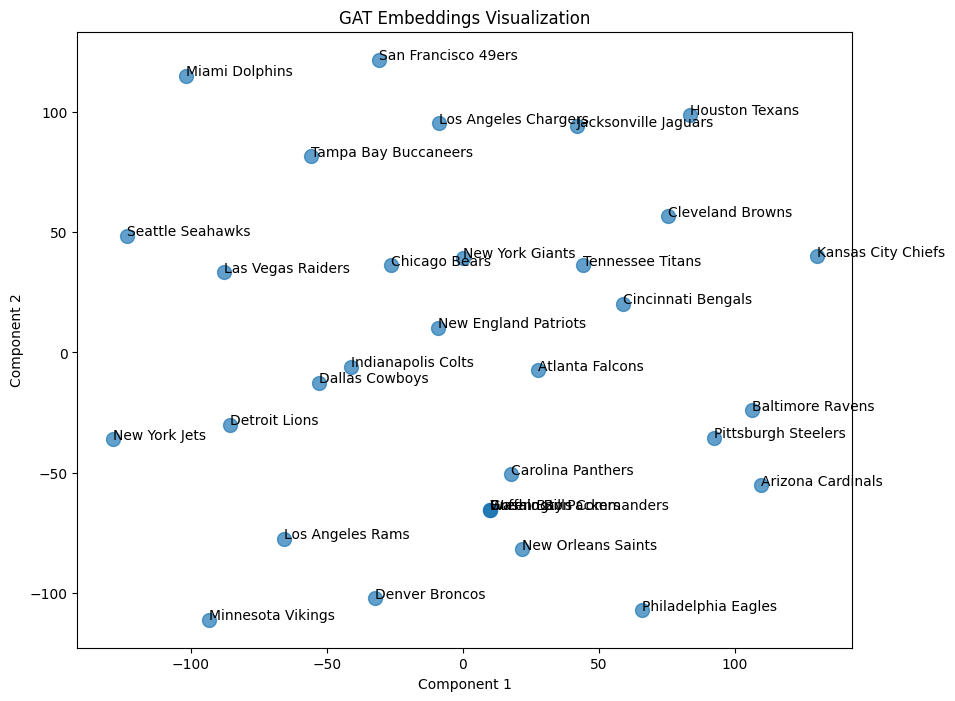

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

embeddings_np = embeddings.cpu().numpy()

tsne = TSNE(n_components=3, random_state=0)
reduced_embeddings = tsne.fit_transform(embeddings_np)

# Plot the reduced embeddings
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=100, alpha=0.7)
plt.title("GAT Embeddings Visualization")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

for i, team in enumerate(teams):
    plt.annotate(team, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.show()


In [33]:
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling, train_test_split_edges

In [ ]:
# Initialize the model
in_channels = node_features.size(1)  # Assuming you use random features as before
hidden_channels = 32
out_channels = 16
model = GATModel(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels, num_layers=4).to(device)

data.edge_attr = None

# Perform train/test split on edges
data = train_test_split_edges(data)

# You can still access `edge_attr` separately if needed
edge_attr = data.edge_attr  # Store edge_attr separately if you need it later


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [35]:
import time

In [ ]:
# Training loop

timestr = time.strftime("%Y%m%d-%H%M%S") + "_" + 'GAT' + f'_layers_{model.num_layers}_heads_{model.heads}_hidden_{model.hidden_channels}_dropout_{model.dropout}'
writer = SummaryWriter(log_dir=f'./Graph/{timestr}')
epochs = 10000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # 2. Encode nodes using GAT layers
    z = model.encode(node_features, data.train_pos_edge_index)
    
    # 3. Positive and negative samples for training
    pos_edge_index = data.train_pos_edge_index  # Positive edges from training set
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=z.size(0),
        num_neg_samples=pos_edge_index.size(1)
    )  # Random negative samples
    
    # 4. Decode edges
    pos_pred = model.decode(z, pos_edge_index)
    neg_pred = model.decode(z, neg_edge_index)
    
    # 5. Create labels for positive and negative samples
    pos_label = torch.ones(pos_pred.size(0), device=device)
    neg_label = torch.zeros(neg_pred.size(0), device=device)
    
    # 6. Compute loss (binary cross-entropy)
    loss = F.binary_cross_entropy_with_logits(torch.cat([pos_pred, neg_pred]), torch.cat([pos_label, neg_label]))
    accuracy = ((torch.sigmoid(pos_pred) > 0.5).sum().item() + (torch.sigmoid(neg_pred) <= 0.5).sum().item()) / (pos_label.size(0) + neg_label.size(0))
    
    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Accuracy/train', accuracy, epoch)
    
    # validation loss
    val_pos_edge_index = data.val_pos_edge_index 
    val_neg_edge_index = negative_sampling(
        edge_index=data.val_pos_edge_index,
        num_nodes=z.size(0),
        num_neg_samples=val_pos_edge_index.size(1)
    )  # Random negative samples
    
    val_pos_pred = model.decode(z, val_pos_edge_index)
    val_neg_pred = model.decode(z, val_neg_edge_index)
    
    val_pos_label = torch.ones(val_pos_pred.size(0), device=device)
    val_neg_label = torch.zeros(val_neg_pred.size(0), device=device)
    
    val_loss = F.binary_cross_entropy_with_logits(torch.cat([val_pos_pred, val_neg_pred]), torch.cat([val_pos_label, val_neg_label]))
    val_accuracy = ((torch.sigmoid(val_pos_pred) > 0.5).sum().item() + (torch.sigmoid(val_neg_pred) <= 0.5).sum().item()) / (val_pos_label.size(0) + val_neg_label.size(0))
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/val', val_accuracy, epoch)
    
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss.item()}, Training Accuracy: {accuracy}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy}")

model.eval()
with torch.no_grad():
    z = model.encode(node_features, data.train_pos_edge_index)
    pos_pred = model.decode(z, data.test_pos_edge_index)
    neg_pred = model.decode(z, data.test_neg_edge_index)
    
    pos_label = torch.ones(pos_pred.size(0), device=device)
    neg_label = torch.zeros(neg_pred.size(0), device=device)
    
    # Concatenate predictions and labels for evaluation
    pred = torch.cat([pos_pred, neg_pred])
    label = torch.cat([pos_label, neg_label])
    
    # Use a threshold (e.g., 0.5) on the sigmoid output to classify edges
    pred_class = (torch.sigmoid(pred) > 0.5).float()
    accuracy = (pred_class == label).sum().item() / label.size(0)
    
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/10000, Training Loss: 75.27072143554688, Training Accuracy: 0.5294117647058824, Validation Loss: 0.6457369327545166, Validation Accuracy: 0.5
Epoch 2/10000, Training Loss: 40.19029998779297, Training Accuracy: 0.5269607843137255, Validation Loss: 74.21609497070312, Validation Accuracy: 0.3333333333333333
Epoch 3/10000, Training Loss: 184.91159057617188, Training Accuracy: 0.5196078431372549, Validation Loss: 161.7522430419922, Validation Accuracy: 0.6666666666666666
Epoch 4/10000, Training Loss: 41.16419219970703, Training Accuracy: 0.48284313725490197, Validation Loss: 1.2063660621643066, Validation Accuracy: 0.5
Epoch 5/10000, Training Loss: 87.22949981689453, Training Accuracy: 0.48284313725490197, Validation Loss: 3.905700922012329, Validation Accuracy: 0.75
Epoch 6/10000, Training Loss: 79.09565734863281, Training Accuracy: 0.5980392156862745, Validation Loss: 2.4483683109283447, Validation Accuracy: 0.5833333333333334
Epoch 7/10000, Training Loss: 281.43157958984375, Trai

In [ ]:
data = Data(edge_index=edge_index, edge_attr=edge_attr, num_nodes=len(teams))
with torch.no_grad():
    embeddings = model.encode(node_features, data.edge_index)

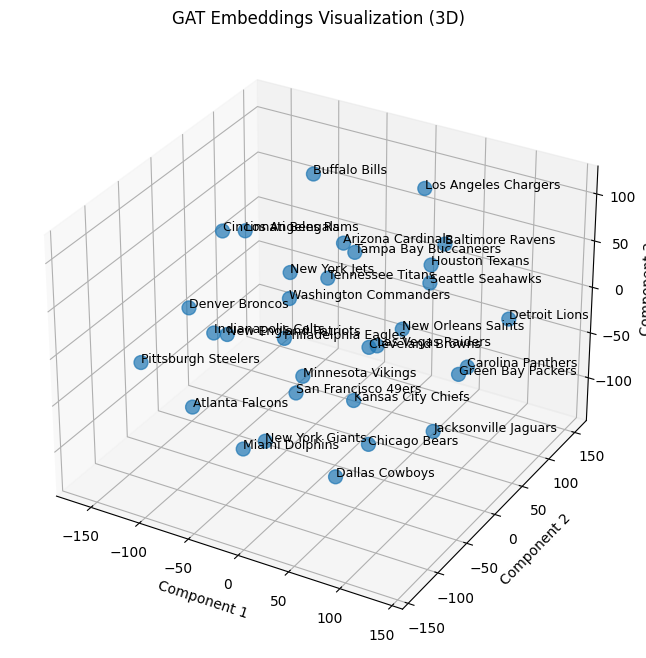

In [ ]:
# Assuming `embeddings` is a tensor of shape [num_nodes, embedding_dim]
embeddings_np = embeddings.cpu().numpy()  # Convert to NumPy for compatibility with sklearn
tsne = TSNE(n_components=3, random_state=0)
reduced_embeddings = tsne.fit_transform(embeddings_np)

from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# Assuming `reduced_embeddings` has 3 dimensions (from t-SNE with `n_components=3`)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the 3D scatter plot
ax.scatter(
    reduced_embeddings[:, 0],  # X-axis
    reduced_embeddings[:, 1],  # Y-axis
    reduced_embeddings[:, 2],  # Z-axis
    s=100, alpha=0.7
)

ax.set_title("GAT Embeddings Visualization (3D)")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")

for i, team in enumerate(teams):
    ax.text(
        reduced_embeddings[i, 0],
        reduced_embeddings[i, 1],
        reduced_embeddings[i, 2],
        team,
        fontsize=9
    )

plt.show()

plt.show()